# Laboratorio 1

- Daniel Alfredo Rayo Roldan
- Gerardo Pineda Riveiro

## Repo:
https://github.com/DanielRasho/DS-Lab2.git

In [1]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input


from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

## Cargado de datos

### Consumo de Gas Licuado

Para el consumo de gas licuado por (dado en barriles de 42 galones) se contaron con registros mensuales desde 2020 hasta 2024, sumando un total de 300 registros.

| Inicio | Fin |Registros totales |
|--------|-----|------------------|
| 2020   | 2024| 300 |

In [2]:
hoja_df = pd.read_excel("./CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

# Select just necesary columns
gas_df = hoja_df[["Fecha", "Gas licuado de petróleo", "Año", "Mes"]]
gas_df = gas_df.set_index('Fecha').sort_index()
gas_df.head()

,Gas licuado de petróleo,Año,Mes
Fecha,,,
2000-01-01,194410.476190,2000,1
2000-02-01,174710.552381,2000,2
2000-03-01,189234.066667,2000,3
2000-04-01,174330.607143,2000,4
2000-05-01,191745.147619,2000,5


La serie temporal se puede ver en la figura siguiente, se puede apreciar una tendencia creciente desde 2020, teniendo una bajada abrupta (como es de esperar) durante el inicio de pandemia, la intención de este reporte buscara crear un modelo LSTM que prediga los ultimos 3 años registrado en la serie.

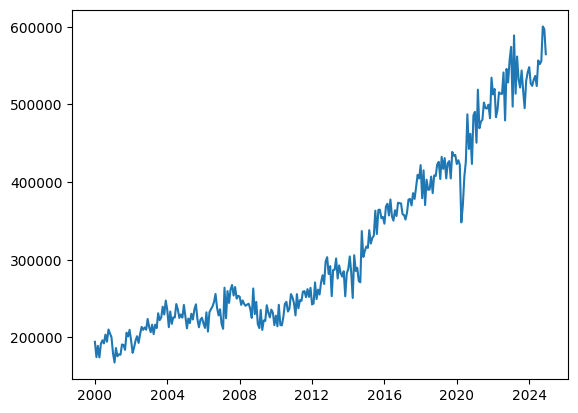

In [3]:
plt.plot(gas_df['Gas licuado de petróleo'])

Para eliminar los sesgos que pueda incurrir la media movil en las predicciones del modelo, se aplicara una diferenciacion; la nueva seria se visualiza en la siguiente figura, se puede observar como todos los datos giran alrededor del 0.

In [4]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = gas_df["Gas licuado de petróleo"].diff()
ts_air_pas_diff.fillna(0, inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.516841e+00
p-value                      3.140557e-16
# de retardos usados         5.000000e+00
# de observaciones usadas    2.940000e+02
Critical Value (1%)         -3.452790e+00
Critical Value (5%)         -2.871422e+00
Critical Value (10%)        -2.572035e+00
dtype: float64


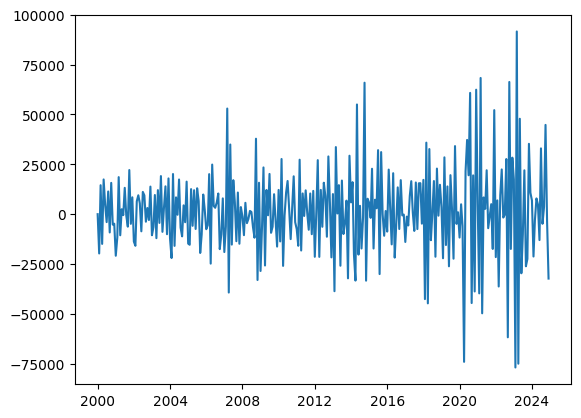

In [5]:
plt.plot(ts_air_pas_diff)

## Conjuntos de entrenamiento y prueba

Para el entrenamiento de la red neuronal LSTM los datos serán divididos en los siguientes grupos:

- 60% entrenamiento (178 registros)
- 20% validación (61 registros)
- 20% test (61 registros)

Antes de ser llevados al modelo serán estandarizados, el código para realizar esa preparación encuentra a continuación.

In [6]:
# Estandarización de los datos
df = ts_air_pas_diff.to_frame();
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(df[["Gas licuado de petróleo"]])

In [7]:
# División en los diferentes grupos
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

A diferencia de otros algoritmos, las redes LSTM utilizan los datos de respuesta tan solo son otro valor de la serie unos cuantos registros más adelante. En este caso, debido a la baja cantidad de datos se utilizará 1 retraso, es decir :

$$y = x_{n+1}$$

In [8]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [9]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

60

## Modelo 1

La arquitectura del primer model consta de una capa de inputs, seguido de la capa LSTM que recibe todos los inputs en un solo lote, para terminar con una red neuronal densa que evalue el output. Para este primer modelo se usara Adam como algoritmo de optmización y MSE como métrica de optomizazión.

In [10]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
#modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [12]:
epocas = 75
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=0
)

A continuación se ven las lineas de aprendizaje del modelo durante su entrenamiento se puede ver como el error de validación disminuye con el paso de las epocas, comparado al error con los datos de entrenamiento indicando que el modelo esta aprendiendo los patrones de las serie.

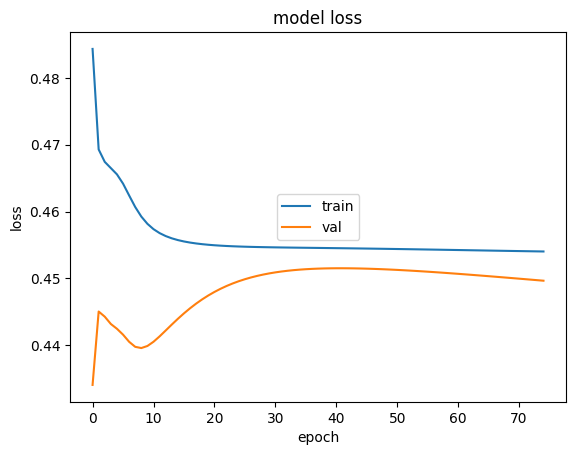

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

El siguiente grafico muestras las lineas de aprendizaje usando diferentes métricas, en todos los casos los errores para validación y entrenamiento se mantienen cerca, indicando que aunque el modelo aprende, no tiene sobreajuste.

<Axes: >

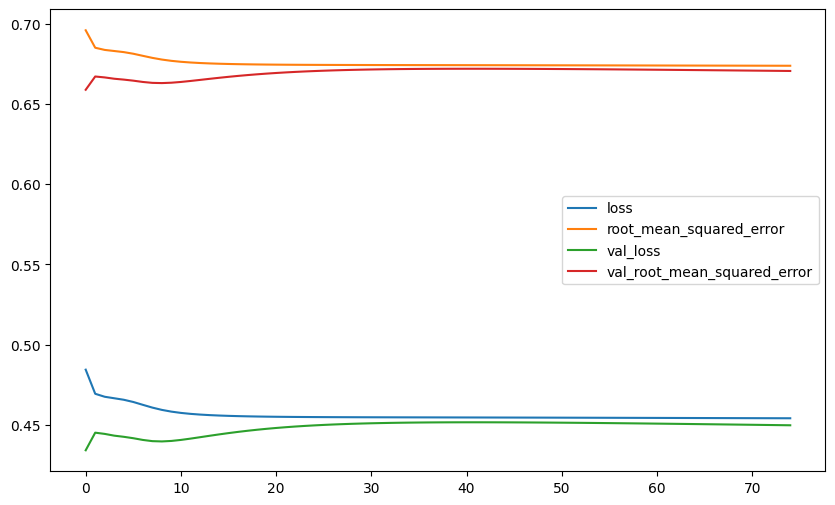

In [14]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

A continuación se realizaran las predicciones con el conjunto de prueba, dado que el modelo fue entrenado usando los datos estandarizados y diferenciados será necesario invertir estas transformaciones en los datos predichos por el modelo antes de calcular cualquier métrica.

In [15]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = []
    reales = []
    
    for i, X in enumerate(data):
        index = n + dif_cant * i
        next_index = index + dif_cant

        if next_index >= len(Series):
            break  # Stop if we can't get a valid real value
        
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invert scaling
        yhat = scaler.inverse_transform(yhat)
        
        if dif:
            # Invert differencing
            yhat = yhat + Series[index]
            reales.append(Series[next_index])
        else:
            reales.append(Series[index])
        
        prediccion.append(yhat[0][0])
    
    return prediccion, reales
prediccion_val, val_real = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento+val_prueba)


Estas son las métricas de error reales para el modelo, en promedio se el modelo se desfasa aproximadamente 39.5 mil barriles con respecto al valor verdadero, lo cuál es un error aceptable considerando que las predicciones se dan en el orden de los cien miles.

In [16]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Number of observations
n = len(y_test_flat)

y_test_flat_temp = np.array(test_real)
y_pred_flat_temp = np.array(prediccion_test)
rss = np.sum((y_test_flat_temp - y_pred_flat_temp) ** 2)

k = modelo1.count_params()

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)
r2 = round(r2_score(y_test_flat, y_pred_flat), 5)

# AIC and BIC
aic = round(n * np.log(rss / n) + 2 * k, 5)
bic = round(n * np.log(rss / n) + k * np.log(n), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "AIC": [aic],
    "BIC": [bic]
})

metrics_df.transpose()

,0
MAE,3.024353e+04
MSE,1.562326e+09
RMSE,3.952627e+04
AIC,1.276997e+03
BIC,1.306083e+03


In [17]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gas licuado de petróleo"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gas licuado de petróleo"]].iloc[start:end].index)


La gráfica también refuerza la idea, mostrando que el modelo logra ajustarse a los picos y valles de la serie, incluso durante el comportamiento atípico de pandemia.

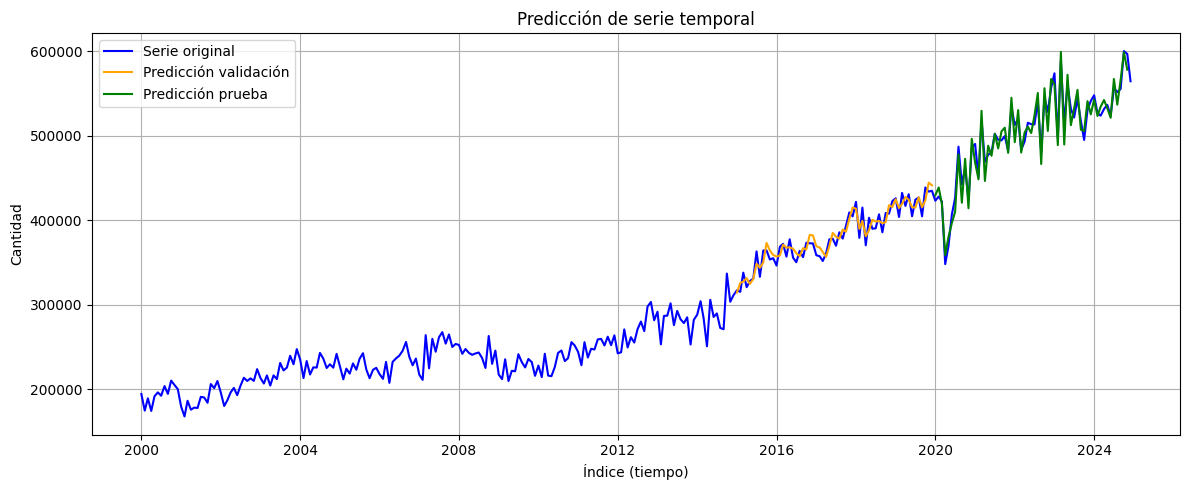

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(gas_df[["Gas licuado de petróleo"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Modelo 2

Para el siguiente modelo se utilizo un buscador de hiperparámetros que probara con diferentes convinaciones para encontrar aquella que diera mejor rendimiento, se variaron los parámetros de : 

- Unidades
- Optimizador
- Taza de aprendizaje

El MSE siguio siendo la métrica a optimizar.

In [19]:
from keras_tuner import HyperParameters, RandomSearch
from tensorflow.keras.optimizers import Adam, SGD

def build_model(hp):
    model = Sequential()
    
    lote = 1
    paso = 1
    caracteristicas = 1  # Adjust if your input shape changes

    # Tune number of LSTM units
    unidades = hp.Int("units", min_value=4, max_value=64, step=4)
    
    # Tune optimizer choice
    optimizer_name = hp.Choice("optimizer", ["adam", "sgd"])
    
    # Tune learning rate
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.add(Input(batch_shape=(lote, paso, caracteristicas)))
    model.add(LSTM(units=unidades, stateful=True))
    model.add(Dense(1))

    # Create optimizer with tuned learning rate
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [20]:
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="gas_forecasting"
)

tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=1,  # Must match `lote`
    shuffle=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Reloading Tuner from lstm_tuning\gas_forecasting\tuner0.json


In [21]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Build the model again using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train it again and save the history
epocas = 95
history = best_model.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,  # Must match stateful batch shape
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    verbose=0
)

Las curvas de aprendizaje del modelo, disminuyen sumamente el error con respecto al modelo 1. En las últimas epocas parece que el modelo desaprendio algunos de los patrones, lo cual podría ser positivo para evitar sobreajuste.

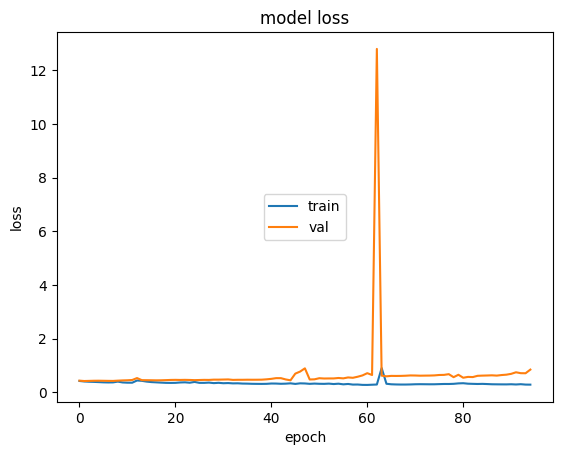

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [23]:
prediccion_val, val_real = prediccion_fun(x_val,best_model, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,best_model, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento+val_prueba)

In [24]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gas licuado de petróleo"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gas licuado de petróleo"]].iloc[start:end].index)


Sin embargo, las métricas de error para este modelo parecen ser ligeramente peores, indicando que la configuración previa ya se encontraba en sus rangos optimos. Se puede concluir que el ajuste de parámetros no da una mejora significativa en la calidad de predicciones.

In [25]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Number of observations
n = len(y_test_flat)

y_test_flat_temp = np.array(test_real)
y_pred_flat_temp = np.array(prediccion_test)
rss = np.sum((y_test_flat_temp - y_pred_flat_temp) ** 2)

# Estimate number of model parameters (heuristic: LSTM units + output layer bias + weight)
# This can vary, so if you have the model summary, you can extract model.count_params()
k = modelo1.count_params()

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)

# AIC and BIC
aic = round(n * np.log(rss / n) + 2 * k, 5)
bic = round(n * np.log(rss / n) + k * np.log(n), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "AIC": [aic],
    "BIC": [bic]
})

metrics_df.transpose()

,0
MAE,4.227017e+04
MSE,2.899885e+09
RMSE,5.385058e+04
AIC,1.313488e+03
BIC,1.342574e+03


La gráfica de predicciones tambien parece mostrar un mayor desfase entre la serie original y la predicha por el modelo.

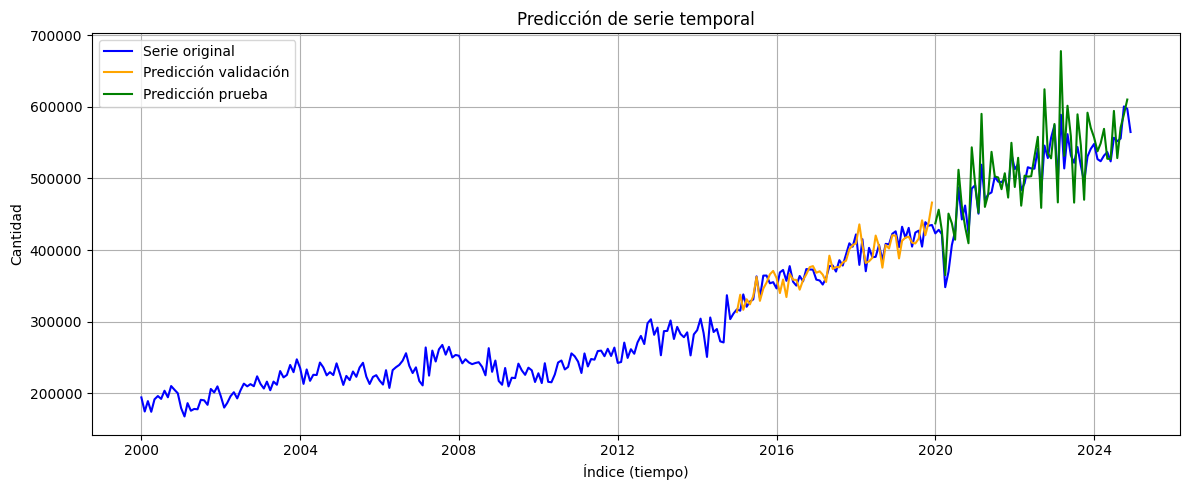

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(gas_df[["Gas licuado de petróleo"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Comparación entre modelos

A continuación se presentaba una tabla con métricas de error para cada modelo, es importante notar que todas las métricas se calcularon para cada modelo.

| Modelo | AIC | BIC | RMSE | MAE |
| -------|-----|-----|------|-----|
| LSTM 1 | 1276.99375 | 1306.07927 | 39525.1635 | 30240.45864 |
| LSTMO tuneo de parametros | 1286.30076 | 1315.38629 | 42768.87076 | 32097.82455 |
| Holt-Winters | 617.61 | 631.28 | | 24936.775 |
| Prophet | 617.31 | 637.82 | | 19578.26 |
| SARIMA  | 5549.75 | 5574.32 | | |

Se puede concluir entonces que Prophet y Holt-Winters fueron los mejores modelos con diferencia en las métricas de AIC BIC, es decir que en relación a su error y tomando en cuenta la complejidad del modelo estos fueron los mejores. Lo mismo se puede decir de las estadisticas MAE, Propeht y Holt-Winters son los mejores, seguidos por las redes LSTM entrenadas en este reporte.

En general las redes LSTM muestran un gran avance comparado a SARIMA, sin embargo todavía no superan modelos preparados como Holt-Winters y prophet, probablemente se requierea algún tipo de tratamiento extra en los datos con los que se entrena el modelo.

# Consumo de Gasolina Super

## Cargado de datos

### Consumo de Gasolina Superior

Para el consumo de Gasolina Superior se contaron con registros mensuales desde 2020 hasta a 2025, sumando un total de 305 registros.

| Inicio | Fin |Registros totales |
|--------|-----|------------------|
| 2020   | mayo-2025| 305 |

In [27]:
hoja_df = pd.read_excel("./CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]

train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]

hoja_df_2025 = pd.read_excel("./VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)

train_data = train_data.drop(columns=["Año", "Mes"])


combined_data = pd.concat([train_data, test_data])
combined_data = combined_data.rename(columns={"Gasolina superior": "super"})
combined_data.set_index("Fecha", inplace=True)


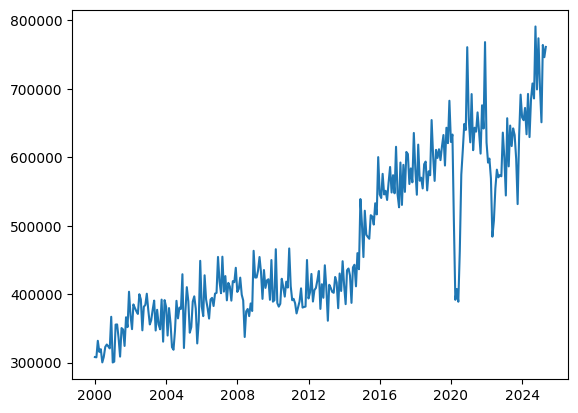

In [28]:
plt.plot(combined_data)

Se puede observar como desde el inicio, la gasolina super ha tenido una tendencia creciente con alta volatilidad de picos crecientes y decrecientes. Algo a destacar es el pico decreciente en 2020 por el COVID-19 pero se puede observar otro pico que sucede a finales de 2022 muy posiblemente por el aumento de precio tan grande que hubo por esas epocas.

In [29]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = combined_data.diff()
ts_air_pas_diff.fillna(0, inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.374157
p-value                        0.000330
# de retardos usados          16.000000
# de observaciones usadas    288.000000
Critical Value (1%)           -3.453262
Critical Value (5%)           -2.871628
Critical Value (10%)          -2.572146
dtype: float64


Se aplica una diferenciacion para estabilizar la media y eliminar la tendencia.

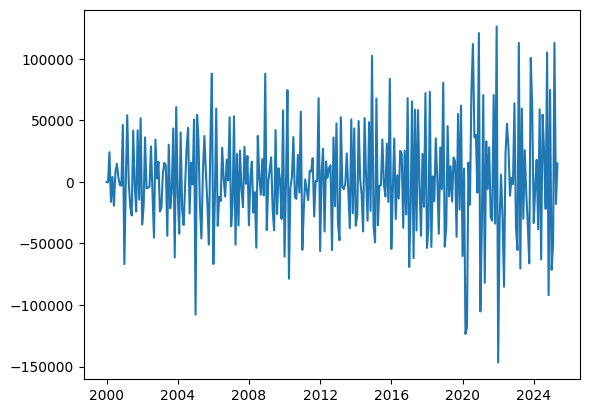

In [30]:
plt.plot(ts_air_pas_diff)

Para el entrenamiento de la red neuronal LSTM los datos serán divididos en los siguientes grupos:

- 60% entrenamiento (183 registros)
- 20% validación (61 registros)
- 20% test (61 registros)

Antes de ser llevados al modelo serán estandarizados, el código para realizar esa preparación encuentra a continuación.

In [31]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(ts_air_pas_diff[["super"]])

In [32]:
# División en los diferentes grupos
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

In [33]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [34]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

61

## Modelo 1

La arquitectura del primer model consta de una capa de inputs, seguido de la capa LSTM que recibe todos los inputs en un solo lote, para terminar con una red neuronal densa que evalue el output. Para este primer modelo se usara Adam como algoritmo de optmización y MSE como métrica de optomizazión.

In [35]:
modelo1 = Sequential()
lote = 1
unidades = 1
paso = 1
caracteristicas = 1  # univariada

modelo1.add(Input(batch_shape=(lote, paso, caracteristicas)))
modelo1.add(LSTM(units=unidades, stateful=True))
modelo1.add(Dense(1))

modelo1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (1, 1)                 │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [37]:
epocas = 95
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4755 - val_loss: 1.0610
Epoch 2/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4670 - val_loss: 1.0476
Epoch 3/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4564 - val_loss: 1.0321
Epoch 4/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4459 - val_loss: 1.0149
Epoch 5/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4357 - val_loss: 0.9967
Epoch 6/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4261 - val_loss: 0.9779
Epoch 7/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4173 - val_loss: 0.9593
Epoch 8/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4095 - val_loss: 0.9413
Epoch 9/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4030 - val_loss: 0.9242
Epoch 10/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3978 - val_loss: 0.9083
Epoch 11/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3939 - val_loss: 0.8937
Epoch 12/95
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

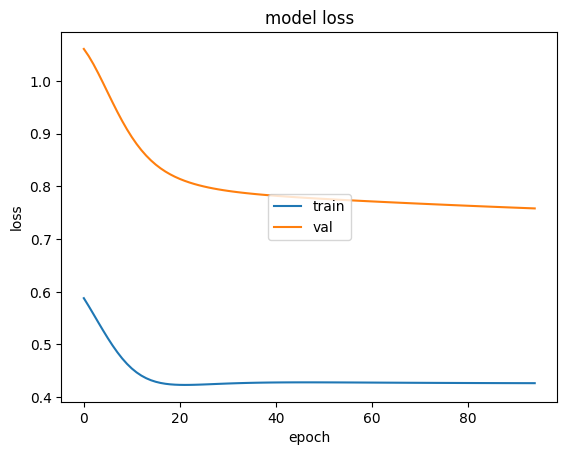

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

En el grafico se observa como el modelo aprende correctamente y no presenta señales de sobreajuste. La perdida se puede observar diminuye ligeramente al inicio pero luego se estabiliza un poco mas alto que su valor minimo.

In [39]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = []
    reales = []
    
    for i, X in enumerate(data):
        index = n + dif_cant * i
        next_index = index + dif_cant

        if next_index >= len(Series):
            break  # Stop if we can't get a valid real value
        
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invert scaling
        yhat = scaler.inverse_transform(yhat)
        
        if dif:
            # Invert differencing
            yhat = yhat + Series[index]
            reales.append(Series[next_index])
        else:
            reales.append(Series[index])
        
        prediccion.append(yhat[0][0])
    
    return prediccion, reales
prediccion_val, val_real = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = combined_data["super"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = combined_data["super"].values , n=entrenamiento+val_prueba)


In [40]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Number of observations
n = len(y_test_flat)

y_test_flat_temp = np.array(test_real)
y_pred_flat_temp = np.array(prediccion_test)
rss = np.sum((y_test_flat_temp - y_pred_flat_temp) ** 2)

# Estimate number of model parameters (heuristic: LSTM units + output layer bias + weight)
# This can vary, so if you have the model summary, you can extract model.count_params()
k = modelo1.count_params()

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)

# AIC and BIC
aic = round(n * np.log(rss / n) + 2 * k, 5)
bic = round(n * np.log(rss / n) + k * np.log(n), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "AIC": [aic],
    "BIC": [bic]
})

metrics_df.transpose()

,0
MAE,5.867837e+04
MSE,5.497755e+09
RMSE,7.414685e+04
AIC,1.373656e+03
BIC,1.402977e+03


Se puede observar en la tabla como el modelo presenta un error considerable siendo bastante elevado. Esto se debe a la inestabilidad de la grafica con muchos picos, haciendo que el modelo no sea preciso en ciertas epocas. El AIC y BIC representan como el modelo ha logrado capturar los datos pero aun existe cierta mejora.

In [41]:
df_val = pd.DataFrame(prediccion_val,
                      index=combined_data[["super"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=combined_data[["super"]].iloc[start:end].index)


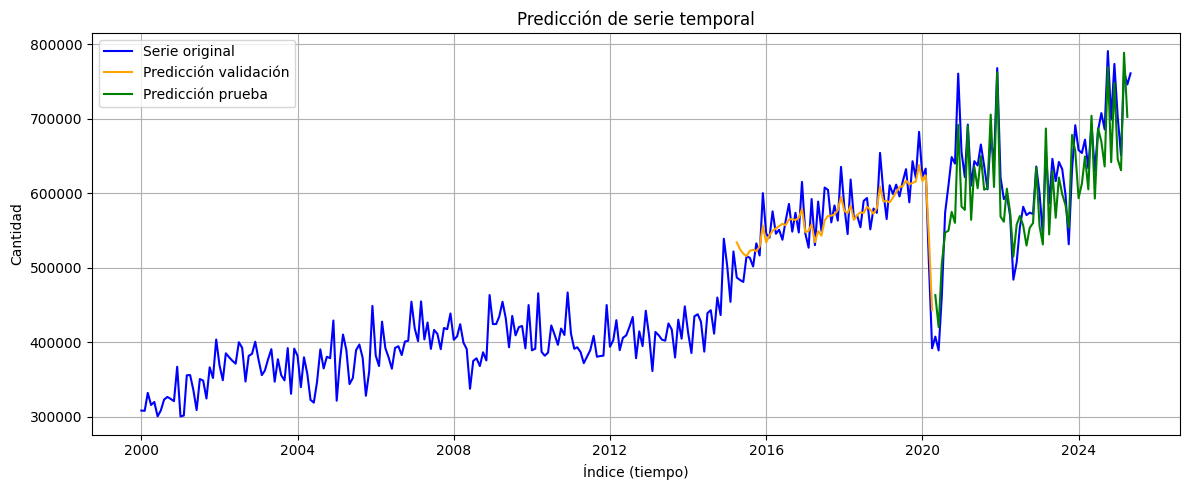

In [42]:
plt.figure(figsize=(12, 5))  

plt.plot(combined_data[["super"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

El modelo sigue batante bien la tendencia, pero no logro capturar totalmente la forma de la grafica. Lo que si se logra observar es como el modelo logra capturar de forma general la serie original con algunas diferencias de amplitud en la prediccion. Se podria suavizar los datos para que el 2020 no afecte a el entrenamiento del modelo

## Modelo 2

Para el siguiente modelo se utilizo un buscador de hiperparámetros que probara con diferentes convinaciones para encontrar aquella que diera mejor rendimiento, se variaron los parámetros de : 

- Numero de capas
- Capas de salida
- Optimizador
- Taza de aprendizaje

El MSE siguio siendo la métrica a optimizar.

In [43]:
from keras_tuner import HyperParameters, RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def build_model(hp: HyperParameters):
    model = Sequential()

    batch_size = 1
    time_steps = 1
    features = 1

    # CApas
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=2)

    for i in range(num_lstm_layers):
        units = hp.Int(f'units_lstm_{i}', min_value=4, max_value=64, step=4)
        dropout_rate = hp.Float(f'dropout_lstm_{i}', min_value=0.0, max_value=0.5, step=0.1)

        return_seq = (i < num_lstm_layers - 1)

        if i == 0:
            model.add(Input(batch_shape=(batch_size, time_steps, features)))
        
        model.add(LSTM(units=units, return_sequences=return_seq, stateful=True))
        model.add(Dropout(rate=dropout_rate))

    # Capas de salida
    activation = hp.Choice("dense_activation", ["linear", "relu"])
    model.add(Dense(1, activation=activation))

    optimizer_name = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        momentum = hp.Float("momentum", 0.0, 0.9, step=0.1)
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer_name == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model


In [44]:
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="gas_forecasting"
)

tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=1, 
    shuffle=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Reloading Tuner from lstm_tuning\gas_forecasting\tuner0.json


In [45]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

best_model = tuner.hypermodel.build(best_hps)

epocas = 95
history = best_model.fit(
    x=x_train,
    y=y_train,
    batch_size=1,
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    verbose=0
)

Se entreno el modelo con los mejores parametros

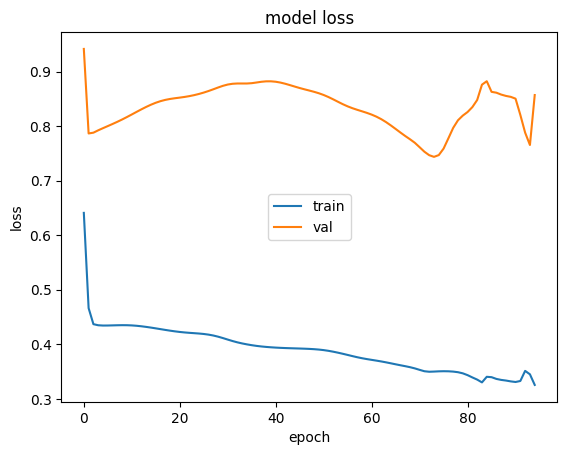

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Se puede observar que la pérdida en el conjunto de entrenamiento disminuye de manera estable y progresiva a lo largo de las épocas, lo cual indica que el modelo está aprendiendo adecuadamente los patrones del conjunto de entrenamiento. 

Sin embargo, el comportamiento de la pérdida en validación no es la mas adecuada. Esto era esperado porque en los datos de validacion se encuentran muchos picos atipico como el 2020, donde no es que no pueda generalizar los datos, si no que los datos son atipicos. Los picos de la grafica naranja no representan fallos en el modelo si no en como estan los datos.

In [47]:
prediccion_val, val_real = prediccion_fun(x_val,best_model, 1,scaler,dif=True,dif_cant=1, Series = combined_data["super"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,best_model, 1,scaler,dif=True,dif_cant=1, Series = combined_data["super"].values , n=entrenamiento+val_prueba)

In [48]:
df_val = pd.DataFrame(prediccion_val,
                      index=combined_data[["super"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=combined_data[["super"]].iloc[start:end].index)


In [49]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Number of observations
n = len(y_test_flat)

y_test_flat_temp = np.array(test_real)
y_pred_flat_temp = np.array(prediccion_test)
rss = np.sum((y_test_flat_temp - y_pred_flat_temp) ** 2)

# Estimate number of model parameters (heuristic: LSTM units + output layer bias + weight)
# This can vary, so if you have the model summary, you can extract model.count_params()
k = best_model.count_params()

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)

# AIC and BIC
aic = round(n * np.log(rss / n) + 2 * k, 5)
bic = round(n * np.log(rss / n) + k * np.log(n), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "AIC": [aic],
    "BIC": [bic]
})

metrics_df.transpose()

,0
MAE,6.106912e+04
MSE,5.651584e+09
RMSE,7.517702e+04
AIC,1.549312e+03
BIC,1.760841e+03


Comparado con el modelo anterior se puede observar como el modelo al cual no se le ajustan hiperparametros es mas eficiente tienendo mejor MAE y RMSE. Junto con el AIC y BIC. Este modelo generaliza bien pero es levemente peor.

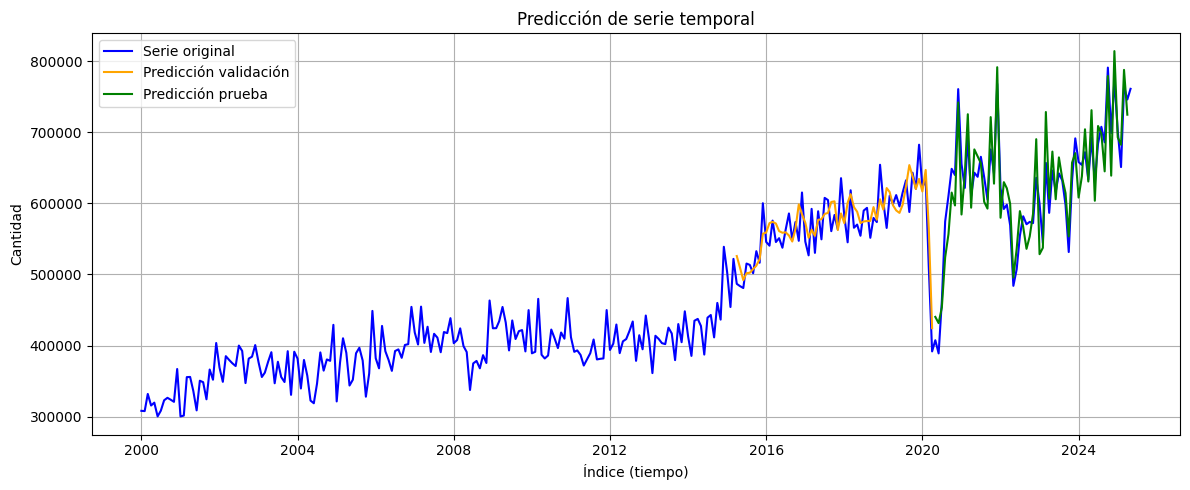

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(combined_data[["super"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Se puede observar como el modelo en validacion no sigue la tendencia, no aprendiendo bien estos datos por el pico decreciente en 2020. Por otro lado en los siguientes años el modelo si se logra predecir los siguientes años aunque no logra capturar la amplitud de los valores.

El mejor modelo es el primero, teniendo una mejor generalizacion y adoptandose mejor a los valores de validacion y prediccion.

### Comparación entre modelos

A continuación se presentaba una tabla con métricas de error para cada modelo, es importante notar que todas las métricas se calcularon para cada modelo.

| Modelo | AIC | BIC | RMSE | MAE |
| -------|-----|-----|------|-----|
| LSTM 1 | 1361.17358 | 1390.49441 | 66821.48061 | 53370.5314 |
| LSTMO tuneo de parametros | 1545.43429 | 1756.96309 | 72786.49927 | 1756.96309 |
| Holt-Winters | 677.07 | 690.75 | | 73433.38591 |
| Prophet | 669.09 | 689.59 | | 46745.24661 |
| SARIMA  | 5861.60994 | 5879.17708 | | |

Se puede concluir entonces que Prophet y Holt-Winters fueron los mejores modelos con diferencia en las métricas de AIC BIC, es decir que en relación a su error y tomando en cuenta la complejidad del modelo estos fueron los mejores. Lo mismo se puede decir de las estadisticas MAE, Propeht y Holt-Winters son los mejores, seguidos por las redes LSTM entrenadas en este reporte.

En general las redes LSTM muestran un gran avance comparado a SARIMA, sin embargo todavía no superan modelos preparados como Holt-Winters y prophet, probablemente se requierea algún tipo de tratamiento extra en los datos con los que se entrena el modelo.